In [1]:
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
%matplotlib inline

import xrft
from glob import glob

In [2]:
# create xarray dataset (each single depth)

E_dir = '/home1/scratch/xyu/mit_spec/E_u_2d/'

for t in np.arange(200):
    ds = xr.Dataset(coords={'time': ('time', np.arange(3000)*3600.)})
    ds = ds.assign(u=np.cos(2.*np.pi*2/86400.*ds.time)+np.random.randn(ds.time.size))

    file_E = E_dir+'E_u_t%02d.nc'%t 
    ds.to_netcdf(file_E, mode='w')


/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/distributed/utils.py:128: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  % (host, default, e), RuntimeWarning)


In [3]:
# 2d xarray dataset

filenames = sorted(glob(E_dir+'E_u_t*.nc'))
%time ds = xr.open_mfdataset(filenames, concat_dim='depth', compat='equals')
print(ds)

CPU times: user 544 ms, sys: 128 ms, total: 672 ms
Wall time: 763 ms
<xarray.Dataset>
Dimensions:  (depth: 200, time: 3000)
Coordinates:
  * time     (time) float64 0.0 3.6e+03 7.2e+03 1.08e+04 1.44e+04 1.8e+04 ...
Dimensions without coordinates: depth
Data variables:
    u        (depth, time) float64 dask.array<shape=(200, 3000), chunksize=(1, 3000)>


In [4]:
# FFT parameters

nfft = 300
noverlap = nfft/2
window = np.hanning(nfft)

T = np.arange(0, len(ds['u'].time)-int(nfft/2), int(nfft/2))

print(T)

[   0  150  300  450  600  750  900 1050 1200 1350 1500 1650 1800 1950
 2100 2250 2400 2550 2700]


In [5]:
# compute and write PSD

for t in T:
    
    u = ds['u'].isel(time=slice(t,t+nfft))   
    #print(u)
    u_fft = xrft.dft(window*u.fillna(0.), dim=['time'], shift=False, detrend='linear', window=True)
    E_u = (u_fft*u_fft.conj()).where(u_fft!=0., drop=False)
    E_u = E_u.astype('f8').rename('E_u')
    file_E = E_dir+'E_u_fft_t%04d.nc'%t 
    E_u.to_netcdf(file_E, mode='w')  

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/xrft/xrft.py:272: FutureWarning: xarray.DataArray.__contains__ currently checks membership in DataArray.coords, but in xarray v0.11 will change to check membership in array values.
  elif d in da:
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/dask/array/chunk.py:228: ComplexWarning: Casting complex values to real discards the imaginary part
  return x.astype(astype_dtype, **kwargs)
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/xrft/xrft.py:272: FutureWarning: xarray.DataArray.__contains__ currently checks membership in DataArray.coords, but in xarray v0.11 will change to check membership in array values.
  elif d in da:
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/dask/array/chunk.py:228: ComplexWarning: Casting complex values to real discards the imaginary part
  return x.astype(astype_dtype, **kwargs)
/home1/datahome/xyu/.miniconda

In [6]:
# blocks data

filenames = sorted(glob(E_dir+'E_u_fft_t*.nc'))
%time ds = xr.open_mfdataset(filenames, concat_dim='blocks', compat='equals')
print(ds)

CPU times: user 72 ms, sys: 16 ms, total: 88 ms
Wall time: 109 ms
<xarray.Dataset>
Dimensions:            (blocks: 19, depth: 200, freq_time: 300)
Coordinates:
  * freq_time          (freq_time) float64 0.0 9.259e-07 1.852e-06 2.778e-06 ...
    freq_time_spacing  float64 9.259e-07
Dimensions without coordinates: blocks, depth
Data variables:
    E_u                (blocks, depth, freq_time) float64 dask.array<shape=(19, 200, 300), chunksize=(1, 200, 300)>


In [7]:
# averaging over blocks

E = (ds.E_u).sum(dim='blocks') / len(ds.blocks)
print(E)

<xarray.DataArray 'E_u' (depth: 200, freq_time: 300)>
dask.array<shape=(200, 300), dtype=float64, chunksize=(200, 300)>
Coordinates:
  * freq_time          (freq_time) float64 0.0 9.259e-07 1.852e-06 2.778e-06 ...
    freq_time_spacing  float64 9.259e-07
Dimensions without coordinates: depth


No handles with labels found to put in legend.
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/matplotlib/axes/_base.py:3129: UserWarning: Attempted to set non-positive xlimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive xlimits for log-scale axis; '
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/matplotlib/axes/_base.py:3449: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


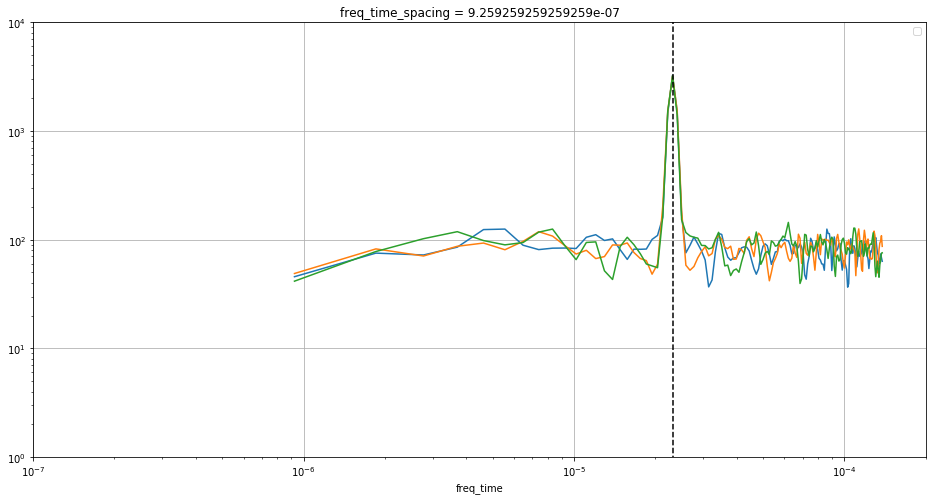

In [8]:
fig, ax = plt.subplots(figsize=(16,8))
E.isel(depth=1).where(E.isel(depth=1).freq_time>0).plot(ax=ax)
ax.legend(); ax.grid()
ax.set_xscale('log'); ax.set_yscale('log')
ax.set_ylabel(''); 

E.isel(depth=2).where(E.isel(depth=2).freq_time>0).plot(ax=ax)
E.isel(depth=20).where(E.isel(depth=20).freq_time>0).plot(ax=ax)

ax.set_xlim([1e-7,2*1e-4])
ax.set_ylim([1e0,1e4])

ax.plot([1/12/3600,1/12/3600],[1e-2,1e6],'k--') 

In [9]:
# averaging over depth

E_mean = E.sum(dim='depth') / len(E.depth)
print(E_mean)

<xarray.DataArray 'E_u' (freq_time: 300)>
dask.array<shape=(300,), dtype=float64, chunksize=(300,)>
Coordinates:
  * freq_time          (freq_time) float64 0.0 9.259e-07 1.852e-06 2.778e-06 ...
    freq_time_spacing  float64 9.259e-07


No handles with labels found to put in legend.
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/matplotlib/axes/_base.py:3129: UserWarning: Attempted to set non-positive xlimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive xlimits for log-scale axis; '
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/matplotlib/axes/_base.py:3449: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


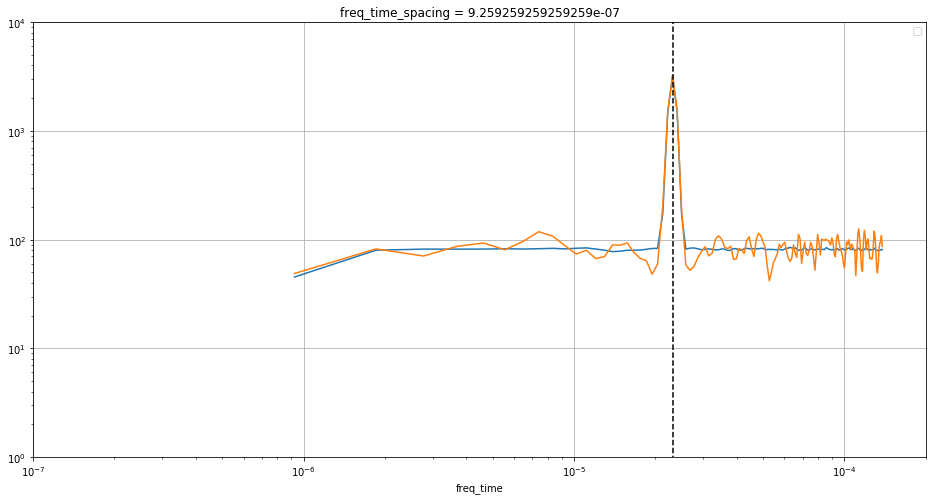

In [10]:
fig, ax = plt.subplots(figsize=(16,8))
E_mean.where(E_mean.freq_time>0).plot(ax=ax)
ax.legend(); ax.grid()
ax.set_xscale('log'); ax.set_yscale('log')
ax.set_ylabel(''); 

E.isel(depth=2).where(E.isel(depth=2).freq_time>0).plot(ax=ax)


ax.set_xlim([1e-7,2*1e-4])
ax.set_ylim([1e0,1e4])

ax.plot([1/12/3600,1/12/3600],[1e-2,1e6],'k--') 